In [1]:
import numpy as np
import scipy as scp
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
import os
import time

# custom convenience functions
from utils.plotting import mid3views

/home/rexfung/github/sigpy-mri-tutorial/.venv/lib/python3.10/site-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
No module named 'cupyx.cudnn'
  warnings.warn(


In [2]:
# Load some data
dataType = '3D'
if dataType == '2D': 
    ksp = scp.io.loadmat('/mnt/storage/rexfung/greTestData/k_mc2d.mat')['k_mc2d']
    ksp = np.transpose(ksp,[2,1,0]) # coil, ky, kx
    ksp = np.flip(ksp, 1) # flip ky dimension
    img_shape = ksp.shape[1:]
elif dataType == '3D':
    ksp = scp.io.loadmat('/mnt/storage/rexfung/greTestData/D_te1.mat')['D_te1']
    ksp = np.transpose(ksp,[3,2,1,0]) # coil, kz, ky, kx
    img_shape = ksp.shape[1:]

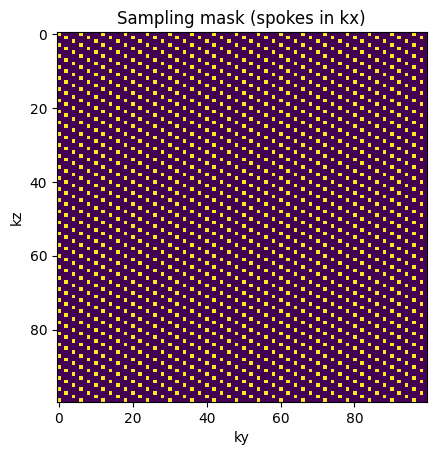

In [3]:
# Retrospectively undersample data
mask = np.zeros(img_shape) # kz, ky, kx for 3D
if dataType == '2D':
    R = 4
    mask[0:None:R,:] = 1
if dataType == '3D':
    Ry = 2
    Rz = 3
    for shift_z in range(Rz):
        mask[shift_z:None:Rz,shift_z*Ry:None:Ry*Rz,:] = 1
ksp_us = mask * ksp

# TODO: Add additional noise simulation
if dataType == '2D':
    plt.figure()
    plt.imshow(mask)
    plt.title('Sampling mask')
    plt.xlabel('kx')
    plt.ylabel('ky')
elif dataType == '3D':
    plt.figure()
    plt.imshow(mask[:,:,0])
    plt.title('Sampling mask (spokes in kx)')
    plt.xlabel('ky')
    plt.ylabel('kz')

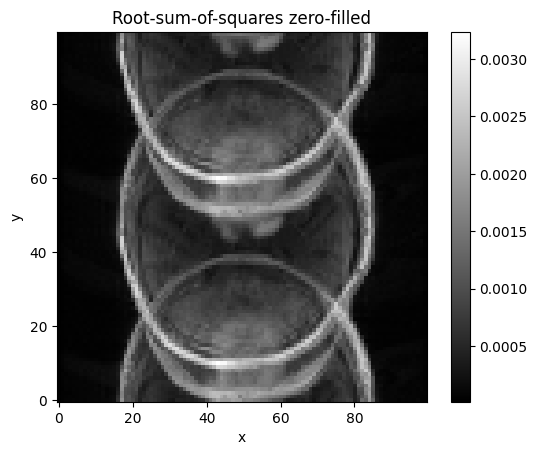

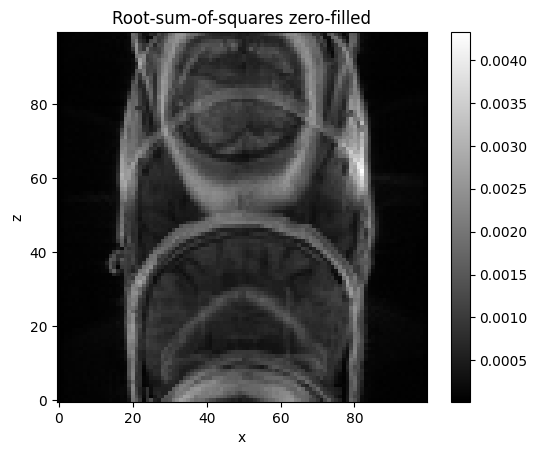

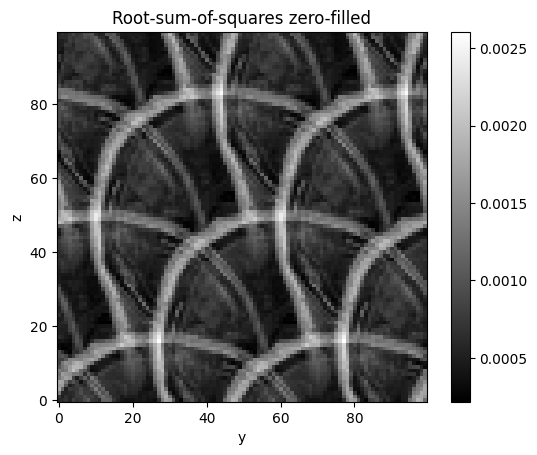

In [4]:
img_rss = np.sum(np.abs(sp.ifft(ksp_us, axes=(-1, -2, -3)))**2, axis=0)**0.5
img_rss /= np.linalg.norm(img_rss)

if dataType == '2D':
    plt.figure()
    plt.imshow(img_rss, cmap='gray', origin='lower')
    plt.title('Root-sum-of-squares Zero-filled')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
elif dataType == '3D': # show the middle 3 views of the image
    mid3views(img_rss, 'Root-sum-of-squares zero-filled')

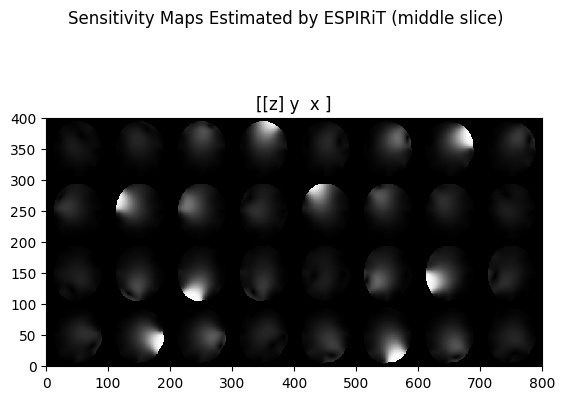

In [5]:
if dataType == '2D':
    mps = mr.app.EspiritCalib(ksp).run()
    pl.ImagePlot(mps, z=0, title='Sensitivity Maps Estimated by ESPIRiT')
elif dataType == '3D':
    if os.path.isfile('D_te1_mps.mat'):
        mps = scp.io.loadmat('D_te1_mps.mat')['D_te1_mps']
    else: # create smaps if not present (takes a long time)
        start = time.time()
        mps = np.zeros_like(ksp)
        hybrid_ksp = sp.ifft(ksp, axes=(-3,)) # coil, z, ky, kx
        for z in range(mps.shape[1]):
            mps[:,z,:,:] = mr.app.EspiritCalib(hybrid_ksp[:,z,:,:],device=0,show_pbar=False).run().get()
        
        # mps = mr.app.EspiritCalib(ksp, device=0).run().get()
        # not possible to estimate entire sensitvity map at once due to memory limit
        end = time.time()
        print(f"Time elapsed: {end - start}")

        # smooth along z since smaps should be smooth. Appears to make the recon worse though...
        # mps = scp.ndimage.uniform_filter1d(mps,10,axis=1)        

        # save it for next time
        D_te1_mps = mps
        mdic = {'D_te1_mps': D_te1_mps}
        scp.io.savemat('D_te1_mps.mat', mdic)
    
    pl.ImagePlot(mps[:,:,:,mps.shape[3]//2], z=0, title='Sensitivity Maps Estimated by ESPIRiT (middle slice)')

    # 3D times:
    # Quickstep CPU: 16 m 42 s
    # Quickstep GPU (device=0, 4x RTX 2080 Ti): 14 s

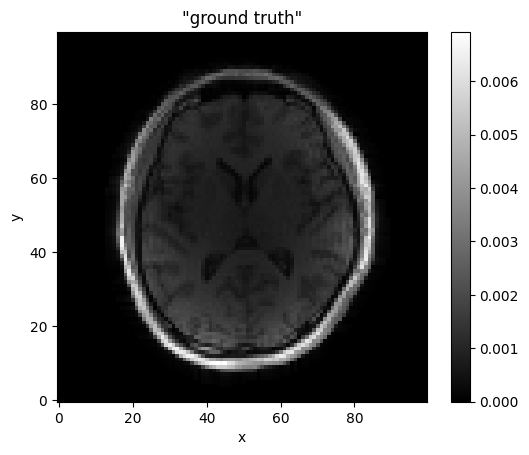

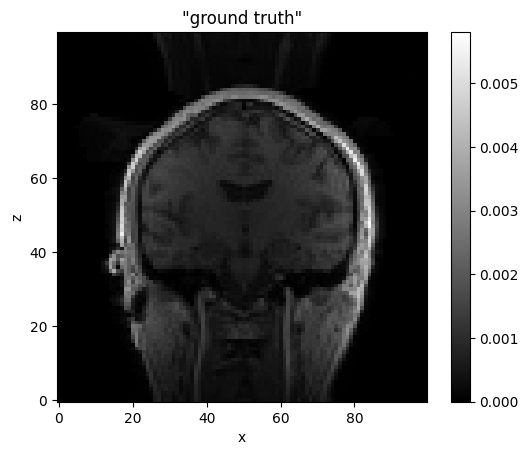

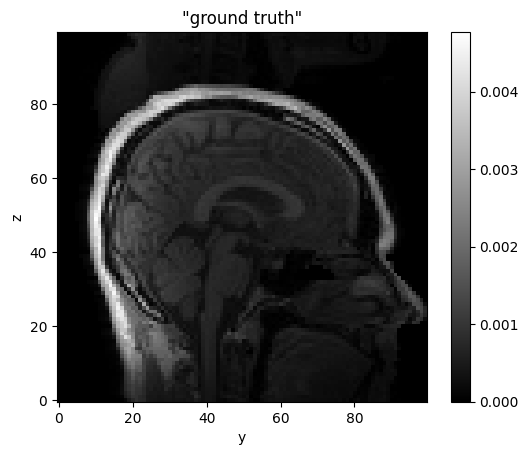

In [6]:
# make ground truth image from fully sampled k-space
if dataType == '2D':
    img_gt = np.sum(np.conj(mps) * sp.ifft(ksp, axes=(-1, -2)), axis=0)
    img_gt /= np.linalg.norm(img_gt)
    plt.figure()
    plt.imshow(np.abs(img_gt), cmap='gray', origin='lower')
    plt.title('"ground truth"')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    
elif dataType == '3D':
    img_gt = np.sum(np.conj(mps) * sp.ifft(ksp, axes=(-1, -2, -3)), axis=0)
    img_gt /= np.linalg.norm(img_gt)
    mag = np.abs(img_gt)
    mid3views(mag, '"ground truth"')

## SENSE Recon

With the sensitivity maps ready, we can now run a SENSE reconstruction using the [SenseRecon](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.SenseRecon.html#sigpy.mri.app.SenseRecon) `App`. We will use an l2 regularization of 0.01 based on trial-and-error with this dataset. Feel free to change it!

Again, we can run the reconstruction on GPU if we specify the `device` option.

SenseRecon:   0%|          | 0/100 [00:00<?, ?it/s]

Time elapsed : 18.79360032081604


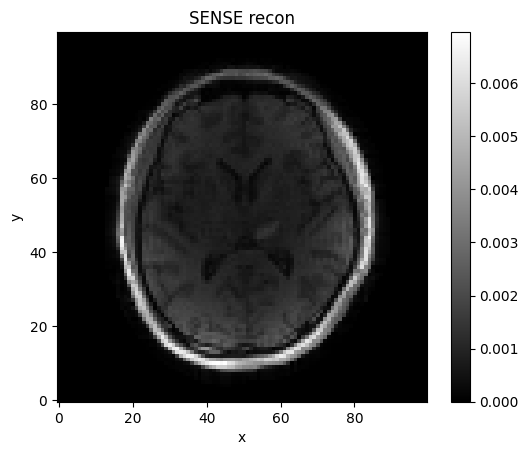

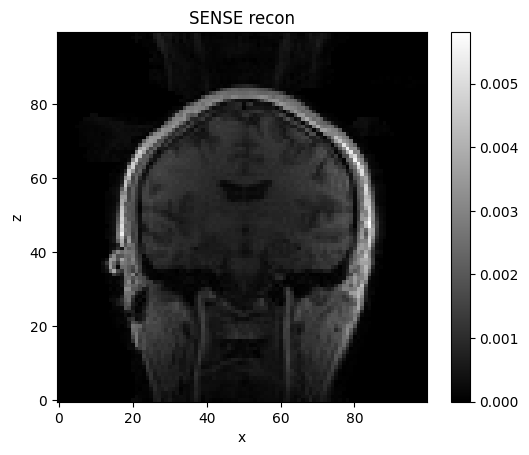

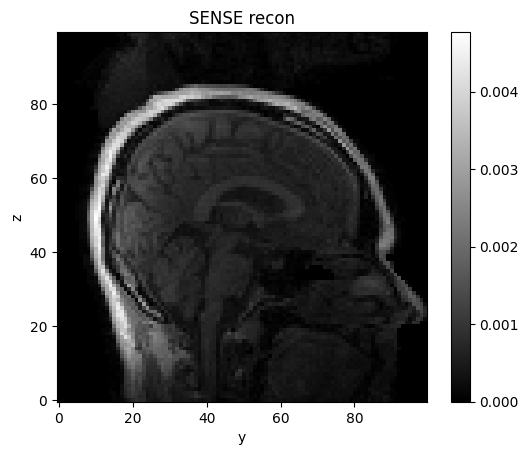

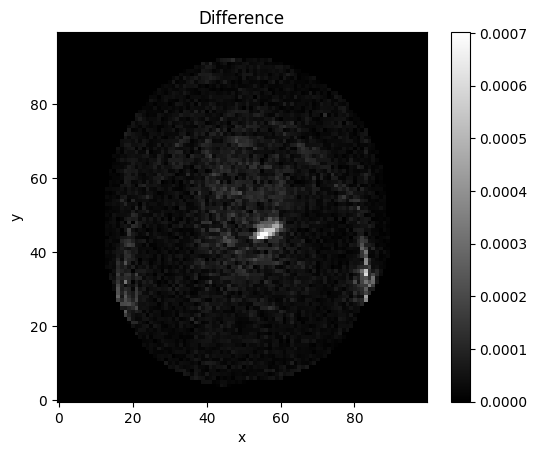

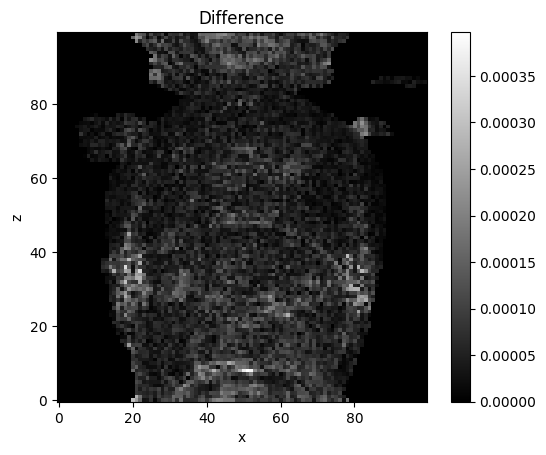

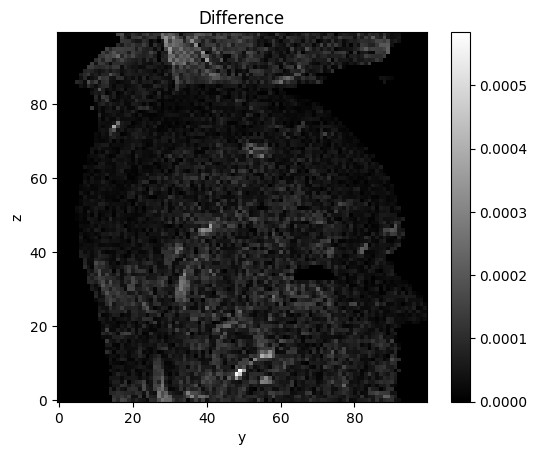

In [7]:
lamda = 0.01
start = time.time()
img_sense = mr.app.SenseRecon(ksp_us, mps, lamda=lamda, device=0).run().get()
end = time.time()
print(f'Time elapsed : {end - start}')
img_sense /= np.linalg.norm(img_sense)

if dataType == '2D':
    plt.figure()
    plt.imshow(np.abs(img_sense), cmap='gray', origin='lower')
    plt.title('SENSE recon')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

    plt.figure()
    plt.imshow(np.abs(img_sense - img_gt), cmap='gray', origin='lower')
    plt.title('Difference')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    
elif dataType == '3D':
    mid3views(np.abs(img_sense), 'SENSE recon')
    mid3views(np.abs(img_sense - img_gt), 'Difference')

# 3D times:
# Quickstep CPU: 9 m 11 s
# Quickstep GPU: 16 s

## L1 Wavelet Regularized Reconstruction

Similarly, we can perform an l1-wavelet regularized reconstruction using [L1WaveletRecon](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.L1WaveletRecon.html#sigpy.mri.app.L1WaveletRecon).

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

L1WaveletRecon:   0%|          | 0/100 [00:00<?, ?it/s]

Time elapsed: 40.699928283691406


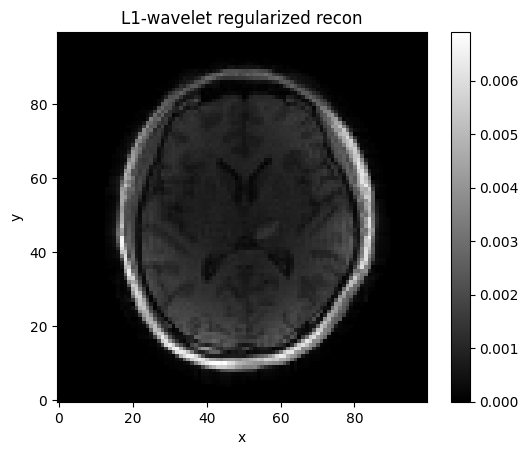

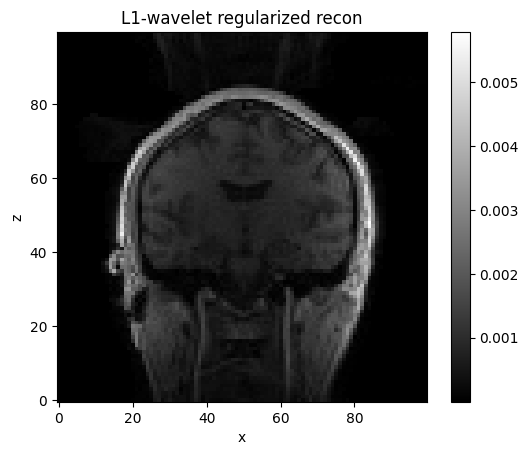

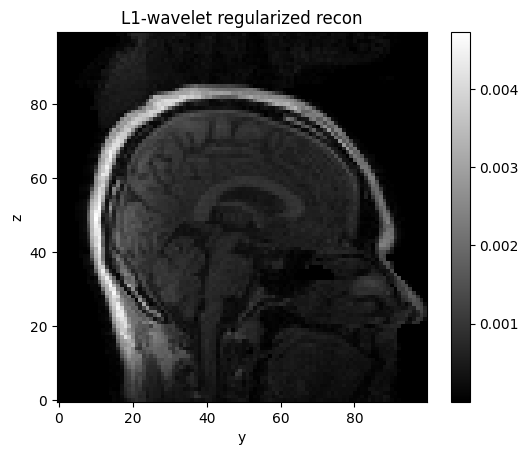

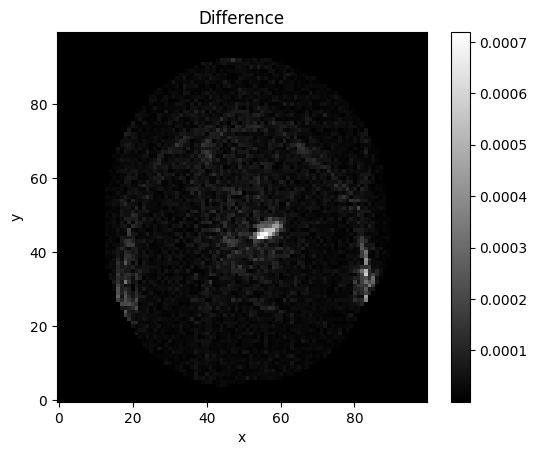

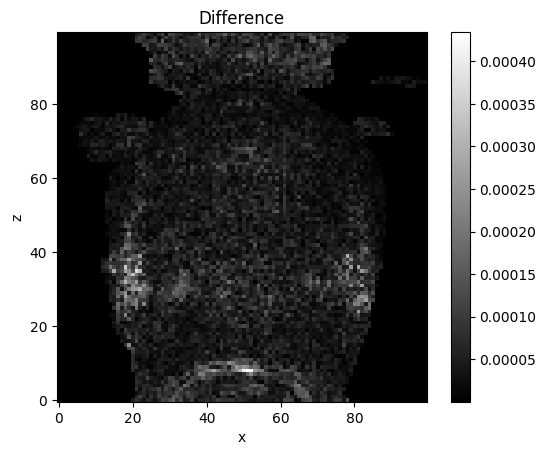

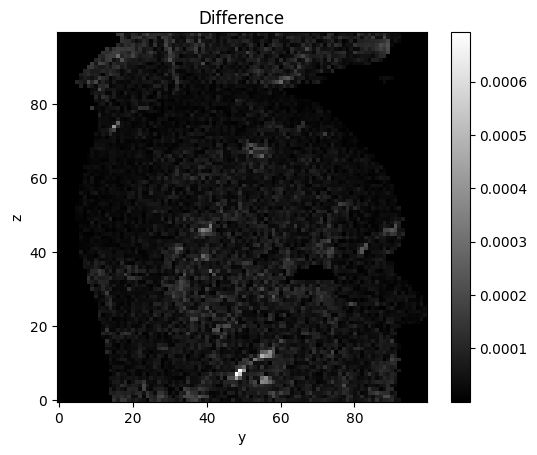

In [8]:
lamda = 0.01
start = time.time()
img_l1wav = mr.app.L1WaveletRecon(ksp_us, mps, lamda, device=0).run().get()
end = time.time()
print(f'Time elapsed: {end - start}')
img_l1wav /= np.linalg.norm(img_l1wav)

if dataType == '2D':
    plt.figure()
    plt.imshow(np.abs(img_l1wav), cmap='gray', origin='lower')
    plt.title('L1-wavelet regularized recon')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

    plt.figure()
    plt.imshow(np.abs(img_l1wav - img_gt), cmap='gray', origin='lower')
    plt.title('Difference')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

elif dataType == '3D':
    mid3views(np.abs(img_l1wav), 'L1-wavelet regularized recon')
    mid3views(np.abs(img_l1wav - img_gt), 'Difference')

# 3D times:
# Quickstep CPU: 12 m 3 s
# Quickstep GPU: 34 s

# Total Variation Recon

And we can do total variation regularized reconstruction with [TotalVariationRecon](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.TotalVariationRecon.html#sigpy.mri.app.TotalVariationRecon).

MaxEig:   0%|          | 0/30 [00:00<?, ?it/s]

TotalVariationRecon:   0%|          | 0/100 [00:00<?, ?it/s]

Time elapsed: 25.14897322654724


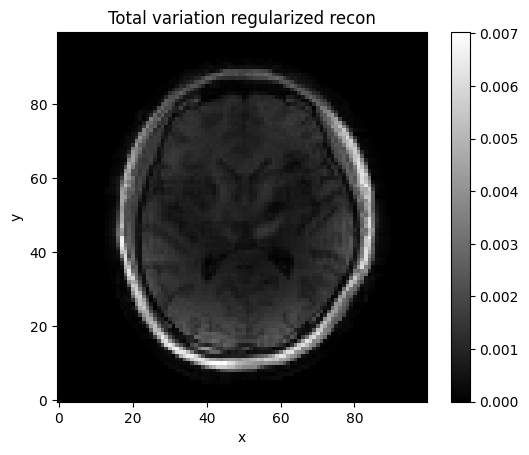

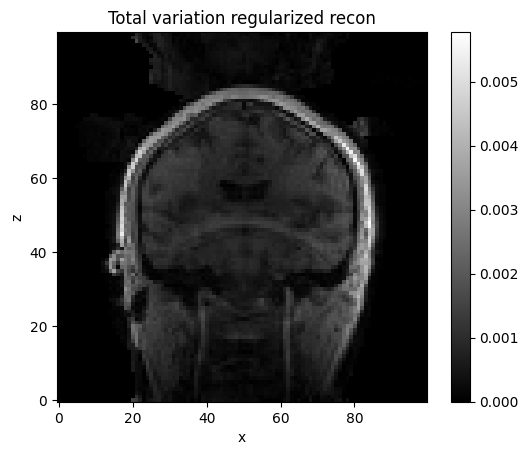

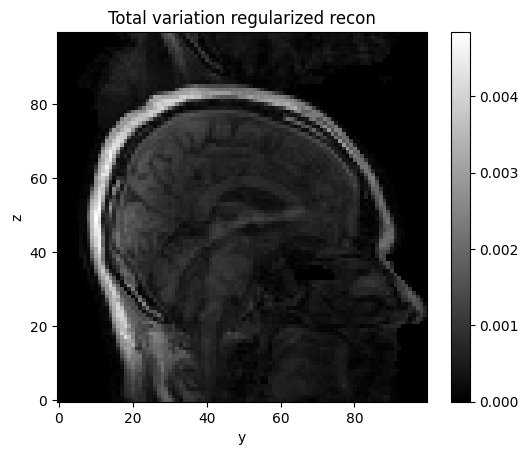

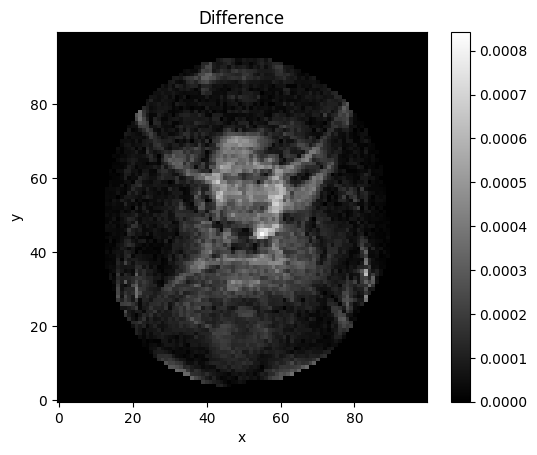

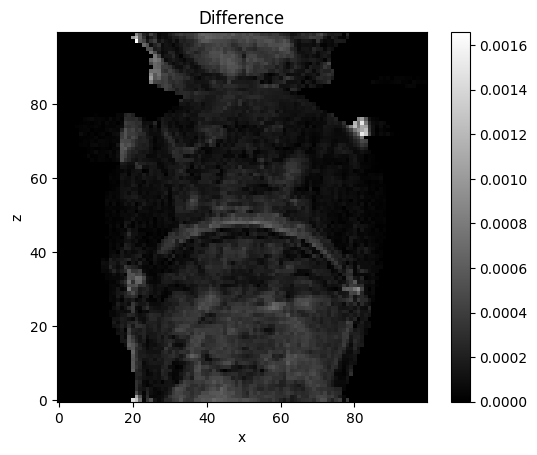

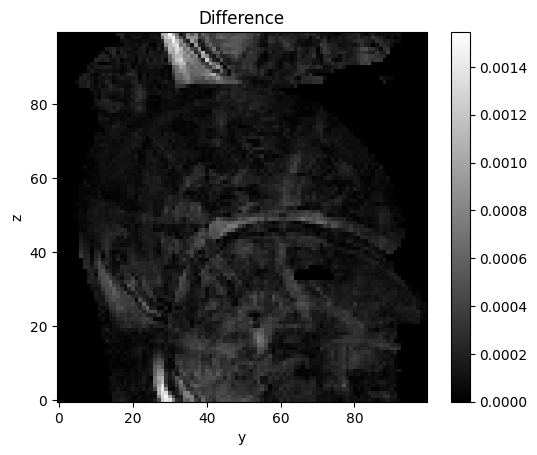

In [9]:
lamda = 1e-3
start = time.time()
img_tv = mr.app.TotalVariationRecon(ksp_us, mps, lamda, device=0).run().get()
end = time.time()
print(f'Time elapsed: {end - start}')
img_tv /= np.linalg.norm(img_tv)

if dataType == '2D':
    plt.figure()
    plt.imshow(np.abs(img_tv), cmap='gray', origin='lower')
    plt.title('Total variation regularized recon')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

    plt.figure()
    plt.imshow(np.abs(img_tv - img_gt), cmap='gray', origin='lower')
    plt.title('Difference')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()

elif dataType == '3D':
    mid3views(np.abs(img_tv), 'Total variation regularized recon')
    mid3views(np.abs(img_tv - img_gt), 'Difference')

# 3D times:
# Quickstep CPU: 14 m 48 s
# Quickstep GPU: 23 s